In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 

**Exploring the data**

#See the dataset structure     
This is a multi-label classification(one sample have multi labels)

In [2]:
df = pd.read_csv("D:/kaggle/toxic_comment/train.csv", encoding = "ISO-8859-1")
print(df.shape)
df.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Number of comments in each category

In [3]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


In [4]:
print(df_stats['category'], df_stats['number_of_comments'])

0            toxic
1     severe_toxic
2          obscene
3           threat
4           insult
5    identity_hate
Name: category, dtype: object 0    15294
1     1595
2     8449
3      478
4     7877
5     1405
Name: number_of_comments, dtype: int64


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

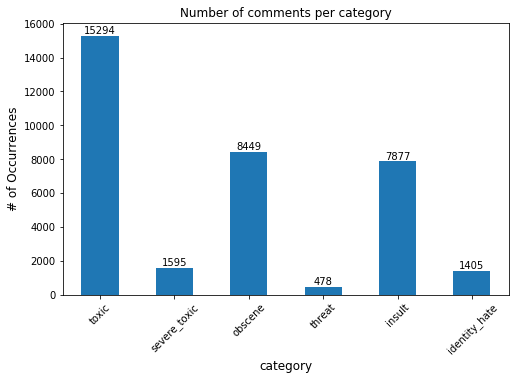

In [5]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=False, figsize=(8, 5))
# Add specific number on the top of every bar
for a,b in zip([i for i in range(len(df_stats.category))], df_stats['number_of_comments']):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.xticks(rotation=45)

**How many comments have multi labels?**   
Vast majority of comment text are not labeled. And There are 6360 samples just have one label.

Text(0.5, 0, '# of categories')

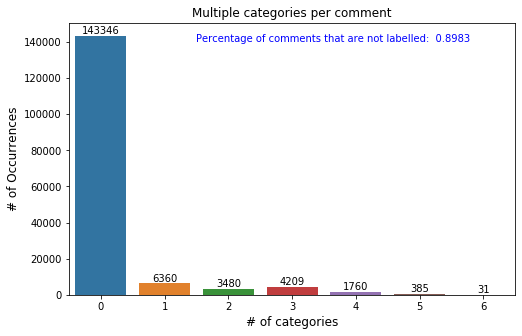

In [6]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()
#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.text(1.5, 140000, r'Percentage of comments that are not labelled:  0.8983',
         fontdict={'size': 10, 'color': 'blue'})
# Add specific number on the top of every bar
for a,b in zip(x.index, x.values):
    plt.text(a, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=10)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [7]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8983211235124177


The distribution of the number of words in commrnt texts.    
Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.     
Average length for comments is 394.712

Average length for comments:	 394.7120842759649


Text(0.5, 0, 'Length of comments')

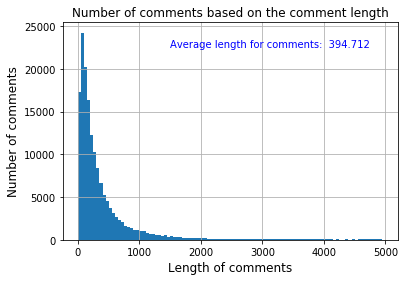

In [8]:
lens = df.comment_text.str.len()
print("Average length for comments:\t", lens.mean())
plt.text(1500, 22500, r'Average length for comments:  394.712',
         fontdict={'size': 10, 'color': 'blue'})
lens.hist(bins = np.arange(0,5000,50))
plt.title("Number of comments based on the comment length")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Length of comments', fontsize=12)

In [9]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

In [10]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

**Data Preprocessing**

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

Clean up comment_text column

In [12]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

Split the data to train and test sets

In [13]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(106912,)
(52659,)


**Evaluation methods**

1. hamming loss (for multi-label classification)   
2. accuracy
3. log loss (log-likelihood loss)

In [14]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
def evaluate_score(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

**Classifiers Training**

Naive Bayes    
OneVsRest multi-label strategy

In [15]:
# Define a pipeline combining a text feature extractor with multi lable classifier
from sklearn.metrics import classification_report
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
predictions = []
for category in categories:
    #print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    predictions.append(NB_pipeline.predict(X_test).tolist())
    
predictions = np.asarray(np.transpose(predictions))
evaluate_score(test[categories], predictions)
print(classification_report(test[categories], predictions, target_names=categories))

Hamming_loss : 3.321369566455876
Accuracy : 89.85928331339372
Log_loss : 1.3884899080987096
               precision    recall  f1-score   support

        toxic       0.99      0.16      0.28      5083
 severe_toxic       0.00      0.00      0.00       526
      obscene       0.99      0.10      0.18      2831
       threat       0.00      0.00      0.00       152
       insult       0.98      0.04      0.07      2643
identity_hate       0.00      0.00      0.00       471

    micro avg       0.99      0.10      0.19     11706
    macro avg       0.49      0.05      0.09     11706
 weighted avg       0.89      0.10      0.18     11706
  samples avg       0.02      0.01      0.01     11706



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


I think precision, recall, f1-score is good for binary or multi-class classification.     
Our task is multi-label classification, hamming loss, log loss will be good

SVM (LinearSVC)

In [16]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
predictions = []
for category in categories:
    #print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    predictions.append(SVC_pipeline.predict(X_test).tolist())
predictions = np.asarray(np.transpose(predictions))
evaluate_score(test[categories], predictions)
print(classification_report(test[categories], predictions, target_names=categories))



Hamming_loss : 1.830962735081689
Accuracy : 91.96338707533374
Log_loss : 1.567103799445703
               precision    recall  f1-score   support

        toxic       0.87      0.69      0.77      5083
 severe_toxic       0.57      0.28      0.38       526
      obscene       0.89      0.70      0.78      2831
       threat       0.63      0.26      0.37       152
       insult       0.79      0.57      0.67      2643
identity_hate       0.64      0.24      0.35       471

    micro avg       0.84      0.62      0.72     11706
    macro avg       0.73      0.46      0.55     11706
 weighted avg       0.83      0.62      0.71     11706
  samples avg       0.06      0.06      0.06     11706



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Logistic Regression

In [17]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
predictions = []
for category in categories:
    #print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    predictions.append(LogReg_pipeline.predict(X_test).tolist())

predictions = np.asarray(np.transpose(predictions))
evaluate_score(test[categories], predictions)
print(classification_report(test[categories], predictions, target_names=categories))

Hamming_loss : 2.0025066940124194
Accuracy : 91.80387018363433
Log_loss : 1.5342835111734687
               precision    recall  f1-score   support

        toxic       0.93      0.58      0.71      5083
 severe_toxic       0.63      0.26      0.36       526
      obscene       0.93      0.60      0.73      2831
       threat       0.71      0.14      0.24       152
       insult       0.82      0.48      0.61      2643
identity_hate       0.69      0.14      0.24       471

    micro avg       0.89      0.52      0.66     11706
    macro avg       0.78      0.37      0.48     11706
 weighted avg       0.88      0.52      0.65     11706
  samples avg       0.05      0.04      0.05     11706



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


kNN

In [18]:
KNN_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(KNeighborsClassifier(n_neighbors=3), n_jobs=1)),
            ])
predictions = []
for category in categories:
    #print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    KNN_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    predictions.append(KNN_pipeline.predict(X_test).tolist())

predictions = np.asarray(np.transpose(predictions))
evaluate_score(test[categories], predictions)
print(classification_report(test[categories], predictions, target_names=categories))

Hamming_loss : 3.2495236648372865
Accuracy : 90.12324578894396
Log_loss : 0.6532458363194418
               precision    recall  f1-score   support

        toxic       0.88      0.16      0.27      5083
 severe_toxic       0.42      0.14      0.21       526
      obscene       0.85      0.19      0.31      2831
       threat       0.54      0.10      0.17       152
       insult       0.75      0.17      0.27      2643
identity_hate       0.65      0.10      0.18       471

    micro avg       0.80      0.17      0.27     11706
    macro avg       0.68      0.14      0.24     11706
 weighted avg       0.81      0.17      0.27     11706
  samples avg       0.01      0.01      0.01     11706



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Random forest

In [19]:
RanFor_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=1)),
            ])
predictions = []
for category in categories:
    #print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    RanFor_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    predictions.append(RanFor_pipeline.predict(X_test).tolist())

predictions = np.asarray(np.transpose(predictions))
evaluate_score(test[categories], predictions)
print(classification_report(test[categories], predictions, target_names=categories))

D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change 

Hamming_loss : 2.251277084638903
Accuracy : 90.99679067205986
Log_loss : 1.8990283016882583
               precision    recall  f1-score   support

        toxic       0.89      0.52      0.66      5083
 severe_toxic       0.53      0.08      0.14       526
      obscene       0.88      0.58      0.70      2831
       threat       0.57      0.05      0.10       152
       insult       0.79      0.42      0.54      2643
identity_hate       0.74      0.08      0.14       471

    micro avg       0.86      0.47      0.61     11706
    macro avg       0.73      0.29      0.38     11706
 weighted avg       0.84      0.47      0.59     11706
  samples avg       0.05      0.04      0.04     11706



D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels.
  'recall', 'true', average, warn_for)


Decision Tree

In [ ]:
DecTree_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(DecisionTreeClassifier(), n_jobs=1)),
            ])
predictions = []
for category in categories:
    #print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    DecTree_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    predictions.append(DecTree_pipeline.predict(X_test).tolist())

predictions = np.asarray(np.transpose(predictions))
evaluate_score(test[categories], predictions)
print(classification_report(test[categories], predictions, target_names=categories))

Neural network

Anlytic 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import itertools

In [ ]:
x = ['Naive Bayes','SVM','Logistic regression',"kNN(k=3)"]
y = [3.32,1.83,2.00,3.67]
plt.ylabel('Hamming-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i])
plt.xticks(rotation=45)
plt.show()

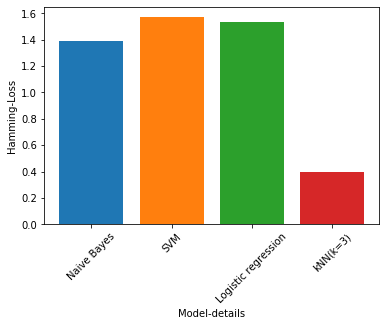

In [35]:
x = ['Naive Bayes','SVM','Logistic regression','kNN(k=3)']
y = [1.39,1.57,1.53,0.40]
plt.ylabel('log-Loss')
plt.xlabel('Model-details')
plt.xticks(rotation=90)
for i in range(len(y)):
    plt.bar(x[i], y[i])
plt.xticks(rotation=45)
plt.show()